In [1]:
import pandas as pd
import numpy as np
import obspy

from obspy.clients.fdsn import Client
from obspy.clients.fdsn import Client as FDSNClient


from pnwstore.mseed import WaveformClient
from datetime import datetime
from matplotlib import pyplot as plt
from obspy import UTCDateTime

from tqdm import tqdm
from obspy.geodetics import locations2degrees, degrees2kilometers
from plot_utils import *

## Morton Catalog

In [2]:
# Read Morton's catalog
events_morton = pd.read_csv('../data/ds01.csv')
# Convert the TSTRING to datetime
events_morton['datetime'] = pd.to_datetime(events_morton['TSTRING'], format='%Y%m%d%H%M%S', utc=True)
# Get the events in the Morton catalog that occurred on 10/14/2012
t1 = pd.Timestamp('2011-1-1 00:00:00.000000+0000', tz='UTC')
t2 = pd.Timestamp('2011-12-31 23:59:59.999999+0000', tz='UTC')

events_morton_201210= events_morton.loc[(events_morton['datetime'] > t1) & (events_morton['datetime'] < t2) ]

events_morton_201210.head()

,CI YEAR,TSTRING,YEAR,MONTH,DAY,HOUR,MINUTE,SECOND,LAT,LON,...,dist to nearest stn,tt RMS,ERH,ERZ,STRIKE,DIP,RAKE,PLATE DESIGNATION,TEMPLATE EVENT?,datetime
0,1.0,2.011073e+13,2011.0,7.0,26.0,1.0,2.0,7.37,47.3217,-123.2708,...,27.4,0.19,0.8,1.2,NaN,NaN,NaN,Interface,Catalog,2011-07-26 01:02:07+00:00
1,1.0,2.011073e+13,2011.0,7.0,26.0,1.0,2.0,7.72,44.2888,-124.3340,...,163.8,0.06,13.1,3.2,NaN,NaN,NaN,Upper Plate,NaN,2011-07-26 01:02:07+00:00
2,1.0,2.011073e+13,2011.0,7.0,26.0,1.0,2.0,8.56,44.3017,-124.3180,...,131.1,0.50,35.4,22.2,NaN,NaN,NaN,Upper Plate,NaN,2011-07-26 01:02:08+00:00
3,1.0,2.011073e+13,2011.0,7.0,26.0,7.0,31.0,2.17,48.2635,-124.9298,...,44.4,0.77,3.5,6.4,NaN,NaN,NaN,Upper Plate,NaN,2011-07-26 07:31:02+00:00
4,1.0,2.011073e+13,2011.0,7.0,26.0,9.0,50.0,27.63,48.3032,-124.9157,...,46.1,0.94,4.0,6.9,NaN,NaN,NaN,Upper Plate,T,2011-07-26 09:50:27+00:00


In [3]:
events_morton_201210

,CI YEAR,TSTRING,YEAR,MONTH,DAY,HOUR,MINUTE,SECOND,LAT,LON,...,dist to nearest stn,tt RMS,ERH,ERZ,STRIKE,DIP,RAKE,PLATE DESIGNATION,TEMPLATE EVENT?,datetime
0,1.0,2.011073e+13,2011.0,7.0,26.0,1.0,2.0,7.37,47.3217,-123.2708,...,27.4,0.19,0.8,1.2,NaN,NaN,NaN,Interface,Catalog,2011-07-26 01:02:07+00:00
1,1.0,2.011073e+13,2011.0,7.0,26.0,1.0,2.0,7.72,44.2888,-124.3340,...,163.8,0.06,13.1,3.2,NaN,NaN,NaN,Upper Plate,NaN,2011-07-26 01:02:07+00:00
2,1.0,2.011073e+13,2011.0,7.0,26.0,1.0,2.0,8.56,44.3017,-124.3180,...,131.1,0.50,35.4,22.2,NaN,NaN,NaN,Upper Plate,NaN,2011-07-26 01:02:08+00:00
3,1.0,2.011073e+13,2011.0,7.0,26.0,7.0,31.0,2.17,48.2635,-124.9298,...,44.4,0.77,3.5,6.4,NaN,NaN,NaN,Upper Plate,NaN,2011-07-26 07:31:02+00:00
4,1.0,2.011073e+13,2011.0,7.0,26.0,9.0,50.0,27.63,48.3032,-124.9157,...,46.1,0.94,4.0,6.9,NaN,NaN,NaN,Upper Plate,T,2011-07-26 09:50:27+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133,1.0,2.011122e+13,2011.0,12.0,23.0,3.0,42.0,54.12,44.3628,-124.4362,...,19.2,0.05,0.4,1.2,NaN,NaN,NaN,Upper Plate,NaN,2011-12-23 03:42:54+00:00
134,1.0,2.011122e+13,2011.0,12.0,24.0,3.0,4.0,31.08,48.1233,-124.5803,...,19.6,0.06,1.7,4.0,NaN,NaN,NaN,Upper Plate,NaN,2011-12-24 03:04:31+00:00
135,1.0,2.011123e+13,2011.0,12.0,28.0,14.0,24.0,39.17,45.4387,-123.8200,...,25.5,0.16,0.7,1.0,NaN,NaN,NaN,Upper Plate,T,2011-12-28 14:24:39+00:00
136,1.0,2.011123e+13,2011.0,12.0,29.0,21.0,36.0,23.94,43.8412,-125.4128,...,51.7,0.39,5.8,4.0,NaN,NaN,NaN,Interface,NaN,2011-12-29 21:36:23+00:00


## ANSS Catalog

In [4]:
events_anss = pd.read_csv('../data/anss_2011-15.csv')
events_anss['datetime'] = pd.to_datetime(events_anss['time'], format='%Y-%m-%dT%H:%M:%S.%fZ', utc=True)
events_anss

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource,datetime
0,2015-12-30T15:14:18.870Z,40.663500,-124.371333,31.190,2.65,md,18.0,215.0,0.11980,0.08,...,near the coast of Northern California,earthquake,0.88,0.87,0.204,41.0,reviewed,nc,nc,2015-12-30 15:14:18.870000+00:00
1,2015-12-30T14:56:15.320Z,43.313800,-126.770100,10.000,3.20,ml,NaN,196.0,1.83800,0.73,...,off the coast of Oregon,earthquake,8.70,2.00,0.056,42.0,reviewed,us,us,2015-12-30 14:56:15.320000+00:00
2,2015-12-30T07:39:29.310Z,48.586500,-123.300333,52.420,4.79,ml,27.0,81.0,0.11670,0.19,...,"12 km SE of North Saanich, Canada",earthquake,0.43,0.67,0.137,178.0,reviewed,uw,uw,2015-12-30 07:39:29.310000+00:00
3,2015-12-29T21:21:55.820Z,40.604667,-124.427500,28.360,2.84,ml,23.0,228.0,0.12790,0.08,...,"14 km WNW of Ferndale, California",earthquake,0.75,0.51,0.270,19.0,reviewed,nc,nc,2015-12-29 21:21:55.820000+00:00
4,2015-12-29T07:33:12.890Z,48.915500,-125.569000,33.970,1.82,ml,4.0,313.0,0.02003,0.10,...,"3 km SSW of Ucluelet, Canada",earthquake,1.23,0.78,0.210,3.0,reviewed,uw,uw,2015-12-29 07:33:12.890000+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4180,2011-01-04T11:32:14.540Z,40.305000,-124.599000,20.290,2.53,md,23.0,241.0,0.22970,0.09,...,"41 km SW of Ferndale, California",earthquake,0.51,0.24,0.211,31.0,reviewed,nc,nc,2011-01-04 11:32:14.540000+00:00
4181,2011-01-03T07:49:17.260Z,40.405333,-123.799667,29.414,2.80,ml,24.0,42.0,0.02613,0.15,...,"12 km E of Redcrest, California",earthquake,0.39,0.87,0.151,15.0,reviewed,nc,nc,2011-01-03 07:49:17.260000+00:00
4182,2011-01-02T22:40:11.410Z,40.315667,-124.593500,17.310,3.79,ml,35.0,241.0,0.22880,0.19,...,"40 km SW of Ferndale, California",earthquake,0.88,0.43,0.198,36.0,reviewed,nc,nc,2011-01-02 22:40:11.410000+00:00
4183,2011-01-02T06:00:27.060Z,40.451167,-125.909333,22.647,3.68,ml,34.0,275.0,1.24000,0.26,...,"140 km W of Ferndale, California",earthquake,3.55,14.43,0.357,12.0,reviewed,nc,nc,2011-01-02 06:00:27.060000+00:00


In [5]:
events_anss

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource,datetime
0,2015-12-30T15:14:18.870Z,40.663500,-124.371333,31.190,2.65,md,18.0,215.0,0.11980,0.08,...,near the coast of Northern California,earthquake,0.88,0.87,0.204,41.0,reviewed,nc,nc,2015-12-30 15:14:18.870000+00:00
1,2015-12-30T14:56:15.320Z,43.313800,-126.770100,10.000,3.20,ml,NaN,196.0,1.83800,0.73,...,off the coast of Oregon,earthquake,8.70,2.00,0.056,42.0,reviewed,us,us,2015-12-30 14:56:15.320000+00:00
2,2015-12-30T07:39:29.310Z,48.586500,-123.300333,52.420,4.79,ml,27.0,81.0,0.11670,0.19,...,"12 km SE of North Saanich, Canada",earthquake,0.43,0.67,0.137,178.0,reviewed,uw,uw,2015-12-30 07:39:29.310000+00:00
3,2015-12-29T21:21:55.820Z,40.604667,-124.427500,28.360,2.84,ml,23.0,228.0,0.12790,0.08,...,"14 km WNW of Ferndale, California",earthquake,0.75,0.51,0.270,19.0,reviewed,nc,nc,2015-12-29 21:21:55.820000+00:00
4,2015-12-29T07:33:12.890Z,48.915500,-125.569000,33.970,1.82,ml,4.0,313.0,0.02003,0.10,...,"3 km SSW of Ucluelet, Canada",earthquake,1.23,0.78,0.210,3.0,reviewed,uw,uw,2015-12-29 07:33:12.890000+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4180,2011-01-04T11:32:14.540Z,40.305000,-124.599000,20.290,2.53,md,23.0,241.0,0.22970,0.09,...,"41 km SW of Ferndale, California",earthquake,0.51,0.24,0.211,31.0,reviewed,nc,nc,2011-01-04 11:32:14.540000+00:00
4181,2011-01-03T07:49:17.260Z,40.405333,-123.799667,29.414,2.80,ml,24.0,42.0,0.02613,0.15,...,"12 km E of Redcrest, California",earthquake,0.39,0.87,0.151,15.0,reviewed,nc,nc,2011-01-03 07:49:17.260000+00:00
4182,2011-01-02T22:40:11.410Z,40.315667,-124.593500,17.310,3.79,ml,35.0,241.0,0.22880,0.19,...,"40 km SW of Ferndale, California",earthquake,0.88,0.43,0.198,36.0,reviewed,nc,nc,2011-01-02 22:40:11.410000+00:00
4183,2011-01-02T06:00:27.060Z,40.451167,-125.909333,22.647,3.68,ml,34.0,275.0,1.24000,0.26,...,"140 km W of Ferndale, California",earthquake,3.55,14.43,0.357,12.0,reviewed,nc,nc,2011-01-02 06:00:27.060000+00:00


## Our Catalog

In [6]:
# Load all the pick assignments 
mycatalog_picks = pd.read_csv('../data/datasets_2011/all_pick_assignments_2011.csv')
mycatalog = mycatalog_picks.drop_duplicates(subset=['idx'])
# Convert the time series in all_pick_assignments to datetime
mycatalog['datetime'] = pd.to_datetime(mycatalog['time'], utc = True)
mycatalog=mycatalog.loc[(mycatalog['datetime'] > t1) & (mycatalog['datetime'] < t2) ]
mycatalog.head()

/tmp/ipykernel_744379/4030592587.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mycatalog['datetime'] = pd.to_datetime(mycatalog['time'], utc = True)


,Unnamed: 0,idx,time,x,y,z,picks,latitude,longitude,depth,event_idx,pick_idx,residual,station,phase,time_pick,datetime
0,0,0,2011-01-02 02:10:45.887104+00:00,14.805304,518.134412,42.578125,12,49.160666,-125.297010,42.578125,0,459812,-0.120669,LZB,P,1.293934e+09,2011-01-02 02:10:45.887104+00:00
12,12,1,2011-01-02 06:00:25.260394+00:00,-32.571669,-405.656546,0.390625,17,40.847633,-125.886246,0.390625,1,421790,-0.245859,DBO,P,1.293948e+09,2011-01-02 06:00:25.260394+00:00
29,29,2,2011-01-02 22:40:10.431510+00:00,53.722104,-433.178816,20.703125,16,40.598696,-124.865315,20.703125,2,421933,-1.029394,DBO,P,1.294008e+09,2011-01-02 22:40:10.431510+00:00
45,45,3,2011-01-03 01:43:16.485751+00:00,79.948643,-440.358538,37.109375,9,40.531931,-124.556410,37.109375,3,270320,0.462323,JCC,P,1.294019e+09,2011-01-03 01:43:16.485751+00:00
54,54,4,2011-01-03 04:37:53.191403+00:00,71.488469,-449.931502,38.671875,12,40.446504,-124.657329,38.671875,4,270328,0.781621,JCC,P,1.294029e+09,2011-01-03 04:37:53.191403+00:00


## Run this loop

In [ ]:
matched_events_mycatalog2morton = []
matched_times_morton2mycatalog = []
matched_events_morton2mycatalog = []
unmatched_times_morton2mycatalog = []
unmatched_events_morton2mycatalog = []
unmatched_events_mycatalog2morton_and_anss = []
matched_events_anss2mycatalog=[]
matched_events_mycatalog2anss = []
unmatched_times_anss2mycatalog = []
unmatched_events_anss2mycatalog = []
matched_times_anss2mycatalog =[]

time_threshold = 5 # in seconds

lat_morton2mycatalog = []
lon_morton2mycatalog = []

lat_anss2mycatalog =[]
lon_anss2mycatalog = []

# A set to keep track of matched indices in mycatalog
matched_indices_morton = set()
matched_indices_anss = set()
count_c = 0
count_d = 0
# Loop over events in Morton's catalog
for i in range(len(events_morton_201210)):
    t11 = events_morton_201210.iloc[i]['datetime']
    time_condition = (mycatalog['datetime'] >= t11 - pd.Timedelta(seconds=time_threshold)) & \
                     (mycatalog['datetime'] <= t11 + pd.Timedelta(seconds=time_threshold))
    matched_df = mycatalog.loc[time_condition]

    if len(matched_df) == 1:
        count_c+=1
        matched_times_morton2mycatalog.append(t11)
        matched_events_morton2mycatalog.append(events_morton_201210.iloc[i])
        lat_morton2mycatalog.append(events_morton_201210.iloc[i]['LAT'])
        lon_morton2mycatalog.append(events_morton_201210.iloc[i]['LON'])
        matched_events_mycatalog2morton.append(matched_df)
        matched_indices_morton.update(matched_df['idx'])
    elif len(matched_df) > 1:
        count_d+=1
        diffs = abs(matched_df['datetime'] - t11)
        closest_index = diffs.idxmin()
        closest_event = matched_df.loc[[closest_index]]
        matched_times_morton2mycatalog.append(t11)
        matched_events_morton2mycatalog.append(events_morton_201210.iloc[i])
        lat_morton2mycatalog.append(events_morton_201210.iloc[i]['LAT'])
        lon_morton2mycatalog.append(events_morton_201210.iloc[i]['LON'])
        matched_events_mycatalog2morton.append(closest_event)
        matched_indices_morton.update(closest_event['idx'])
    else:
        unmatched_times_morton2mycatalog.append(t11)
        unmatched_events_morton2mycatalog.append(events_morton_201210.iloc[i])

# All events in mycatalog not matched with Morton's catalog are unmatched
unmatched_indices_morton = set(mycatalog.idx) - matched_indices_morton
# unmatched_events_mycatalog2morton = mycatalog.iloc[list(unmatched_indices_morton)]
count_a =0
count_b =0
# Loop over events in ANSS catalog
for i in range(len(events_anss)):
    t11 = events_anss.iloc[i]['datetime']
    time_condition = (mycatalog['datetime'] >= t11 - pd.Timedelta(seconds=time_threshold)) & \
                     (mycatalog['datetime'] <= t11 + pd.Timedelta(seconds=time_threshold))
    matched_df = mycatalog.loc[time_condition]

    if len(matched_df) == 1:
        count_a+=1
        matched_times_anss2mycatalog.append(t11)
        matched_events_anss2mycatalog.append(events_anss.iloc[i])
        lat_anss2mycatalog.append(events_anss.iloc[i]['latitude'])
        lon_anss2mycatalog.append(events_anss.iloc[i]['longitude'])
        matched_events_mycatalog2anss.append(matched_df)
        matched_indices_anss.update(matched_df['idx'])
        
    elif len(matched_df) > 1:
        count_b+=1
        diffs = abs(matched_df['datetime'] - t11)
        closest_index = diffs.idxmin()
        closest_event = matched_df.loc[[closest_index]]
        matched_times_anss2mycatalog.append(t11)
        matched_events_anss2mycatalog.append(events_anss.iloc[i])
        lat_anss2mycatalog.append(events_anss.iloc[i]['latitude'])
        lon_anss2mycatalog.append(events_anss.iloc[i]['longitude'])
        matched_events_mycatalog2anss.append(closest_event)
        matched_indices_anss.update(closest_event['idx'])
        
    else:
        unmatched_times_anss2mycatalog.append(t11)
        unmatched_events_anss2mycatalog.append(events_anss.iloc[i])

# All events in mycatalog not matched with ANSS catalog are unmatched
unmatched_indices_anss = set(mycatalog.idx) - matched_indices_anss

unmatched_indices_morton_and_anss = unmatched_indices_morton.intersection(unmatched_indices_anss)

unmatched_events_mycatalog2morton_and_anss = mycatalog.iloc[list(unmatched_indices_morton_and_anss)]

print(f"length of mycatalog:{len(mycatalog)}")
print(f"length of events_morton_201210:{len(events_morton_201210)}")
print(f"length of events_anss:{len(events_anss)}")
print(f"matched_indices_morton:{len(matched_indices_morton)}")
print(f"matched_indices_anss:{len(matched_indices_anss)}")
print(f"unmatched_indices_morton:{len(unmatched_indices_morton)}")
print(f"unmatched_indices_anss:{len(unmatched_indices_anss)}")
print(f"unmatched_indices_morton_and_anss (new events):{len(unmatched_indices_morton_and_anss)}")



In [ ]:
# new concat code
# Concatenate and clean up dataframes
if len(matched_events_mycatalog2morton)>0:
    matched_events_mycatalog2morton = pd.concat(matched_events_mycatalog2morton).reset_index(drop=True)
    matched_times_mycatalog2morton = matched_events_mycatalog2morton['datetime']
    lat_mycatalog2morton = matched_events_mycatalog2morton['latitude']
    lon_mycatalog2morton = matched_events_mycatalog2morton['longitude']

if len(matched_events_morton2mycatalog)>0:   
    matched_events_morton2mycatalog = pd.DataFrame(matched_events_morton2mycatalog).reset_index(drop=True)
    
if len(unmatched_events_anss2mycatalog)>0:
    unmatched_events_anss2mycatalog = pd.DataFrame(unmatched_events_anss2mycatalog).reset_index(drop=True)
    
if len(unmatched_events_morton2mycatalog)>0:
    unmatched_events_morton2mycatalog = pd.DataFrame(unmatched_events_morton2mycatalog).reset_index(drop=True)

if len(unmatched_events_mycatalog2morton_and_anss) > 0:
    unmatched_events_mycatalog2morton_and_anss = unmatched_events_mycatalog2morton_and_anss.reset_index(drop=True)

if len(matched_events_mycatalog2anss)>0:
    matched_events_mycatalog2anss = pd.concat(matched_events_mycatalog2anss).reset_index(drop=True)
    matched_times_mycatalog2anss = matched_events_mycatalog2anss['datetime']
    lat_mycatalog2anss = matched_events_mycatalog2anss['latitude']
    lon_mycatalog2anss = matched_events_mycatalog2anss['longitude']

if len(matched_events_anss2mycatalog)>0:   
    matched_events_anss2mycatalog = pd.DataFrame(matched_events_anss2mycatalog).reset_index(drop=True)
    matched_times_anss2mycatalog = matched_events_anss2mycatalog['datetime']

print(f"length of mycatalog:{len(mycatalog)}")
print(f"length of events_morton_201210:{len(events_morton_201210)}")
print(f"length of events_anss:{len(events_anss)}")
print(f"matched_events_mycatalog2morton:{len(matched_events_mycatalog2morton)}")
print(f"matched_events_morton2mycatalog:{len(matched_events_morton2mycatalog)}")
print(f"unmatched_events_anss2mycatalog:{len(unmatched_events_anss2mycatalog)}")
print(f"unmatched_events_morton2mycatalog:{len(unmatched_events_morton2mycatalog)}")
print(f"unmatched_events_mycatalog2morton_and_anss (new events):{len(unmatched_events_mycatalog2morton_and_anss)}")
print(f"matched_events_mycatalog2anss:{len(matched_events_mycatalog2anss)}")
print(f"matched_events_anss2mycatalog:{len(matched_events_anss2mycatalog)}")

In [ ]:
# Save these three catalogs to csv files
matched_events_mycatalog2morton.to_csv('../data/datasets_2011/matched_events_with_morton_mycatalog.csv')
matched_events_anss2mycatalog.to_csv('../data/datasets_2011/matched_events_with_mycatalog_anss.csv')
matched_events_morton2mycatalog.to_csv('../data/datasets_2011/matched_events_with_mycatalog_morton.csv')
unmatched_events_mycatalog2morton_and_anss.to_csv('../data/datasets_2011/new_events.csv')
matched_events_mycatalog2anss.to_csv('../data/datasets_2011/matched_events_with_anss_mycatalog.csv')
unmatched_events_morton2mycatalog.to_csv('../data/datasets_2011/missing_events_from_mycatalog_morton.csv')
unmatched_events_anss2mycatalog.to_csv('../data/datasets_2011/missing_events_from_mycatalog_anss.csv')


## Plot the Origin Times

### Compare with Morton's Catalog 

In [ ]:
# Make lists for plotting the 1:1 line
x = pd.date_range(start='2011-1-1', end='2011-12-31', periods=len(matched_times_morton2mycatalog))
y = pd.date_range(start='2011-1-1', end='2011-12-31', periods=len(matched_times_morton2mycatalog))

# Plot the scatter plot
plt.figure()
plt.scatter(matched_times_mycatalog2morton,matched_times_morton2mycatalog)
plt.plot(x,y, 'k--')
plt.xlabel('Origin Time of mycatalog')
plt.ylabel('Origin Time of Morton')
plt.title('Scatter Plot: Origin Times of Matched Events')

### Compare with the ANSS Catalog 

In [ ]:
# Make lists for plotting the 1:1 line
matched_times_mycatalog2anss = pd.to_datetime(matched_times_mycatalog2anss)
matched_times_anss2mycatalog = pd.to_datetime(matched_times_anss2mycatalog)

x = pd.date_range(start='2011-1-1', end='2011-12-31', periods=len(matched_times_anss2mycatalog))
y = pd.date_range(start='2011-1-1', end='2011-12-31', periods=len(matched_times_anss2mycatalog))

# Plot the scatter plot
plt.figure()
plt.scatter(matched_times_mycatalog2anss,matched_times_anss2mycatalog)
plt.plot(x,y, 'k--')
plt.xlabel('Origin Time of mycatalog')
plt.ylabel('Origin Time of Morton')
plt.title('Scatter Plot: Origin Times of Matched Events')

## Plot the Latitudes

### Compare with Morton's Catalog 

In [ ]:
# Plot the scatter plot
plt.figure()
lat_min = min(lat_mycatalog2morton)
lat_max = max(lat_mycatalog2morton)

# Make lists for plotting the 1:1 line
x_lat = np.linspace(lat_min, lat_max, 10)
y_lat = np.linspace(lat_min, lat_max, 10)
plt.scatter(lat_mycatalog2morton,lat_morton2mycatalog, s=15)
plt.plot(x_lat,y_lat, 'k--')
plt.xlabel('Latitudes of Our Catalog ($^\circ$)')
plt.ylabel('Latitudes of Morton et al. (2023) ($^\circ$)')
plt.title('Latitudes of Our Catalog vs.Latitudes of Morton et al. (2023)')

### Compare with the ANSS Catalog 

In [ ]:
# Plot the scatter plot
plt.figure()
lat_min = min(lat_mycatalog2anss)
lat_max = max(lat_mycatalog2anss)

# Make lists for plotting the 1:1 line
x_lat = np.linspace(lat_min, lat_max, 10)
y_lat = np.linspace(lat_min, lat_max, 10)
plt.scatter(lat_mycatalog2anss,lat_anss2mycatalog, s=15)
plt.plot(x_lat,y_lat, 'k--')
plt.xlabel('Latitudes of Our Catalog ($^\circ$)')
plt.ylabel('Latitudes of ANSS Catalog ($^\circ$)')
plt.title('Latitudes of Our Catalog vs. ANSS Catalog')

## Plot the Longitudes

### Compare with Morton's Catalog 

In [ ]:
# Plot the scatter plot
plt.figure()
lon_min = min(lon_mycatalog2morton)
lon_max = max(lon_mycatalog2morton)

# Make lists for plotting the 1:1 line
x_lon = np.linspace(lon_min, lon_max, 10)
y_lon = np.linspace(lon_min, lon_max, 10)
plt.scatter(lon_mycatalog2morton,lon_morton2mycatalog)
plt.plot(x_lon,y_lon, 'k--')
plt.xlabel('Longitudes of Our Catalog ($^\circ$)')
plt.ylabel('Longitudes of Morton et al. (2023) ($^\circ$)')
plt.title('Longitudes of Our Catalog vs.Latitudes of Morton et al. (2023)')

### Compare with the ANSS Catalog 

In [ ]:
# Plot the scatter plot
plt.figure()
lon_min = min(lon_mycatalog2anss)
lon_max = max(lon_mycatalog2anss)

# Make lists for plotting the 1:1 line
x_lon = np.linspace(lon_min, lon_max, 10)
y_lon = np.linspace(lon_min, lon_max, 10)
plt.scatter(lon_mycatalog2anss,lon_anss2mycatalog)
plt.plot(x_lon,y_lon, 'k--')
plt.xlabel('Longitudes of Our Catalog ($^\circ$)')
plt.ylabel('Longitudes of Morton et al. (2023) ($^\circ$)')
plt.title('Longitudes of Our Catalog vs.Latitudes of Morton et al. (2023)')

## Depths 

In [ ]:
# Plot the scatter plot
plt.figure()
lon_min = min(lon_mycatalog2anss)
lon_max = max(lon_mycatalog2anss)

# Make lists for plotting the 1:1 line
x_lon = np.linspace(lon_min, lon_max, 10)
y_lon = np.linspace(lon_min, lon_max, 10)
plt.scatter(lon_mycatalog2anss,lon_anss2mycatalog)
plt.plot(x_lon,y_lon, 'k--')
plt.xlabel('Longitudes of Our Catalog ($^\circ$)')
plt.ylabel('Longitudes of Morton et al. (2023) ($^\circ$)')
plt.title('Longitudes of Our Catalog vs.Latitudes of Morton et al. (2023)')

## Histograms
Make histograms of mycatalog vs. Morton's catalog

### Histogram: All of our catalog 

In [ ]:
events_october = pd.read_csv('../data/datasets_2011/events_2011.csv')

In [ ]:
# Plot the same histogram but overlay the histograms
bins = np.linspace(5,30,25)

plt.hist(unmatched_events_mycatalog2morton_and_anss['picks'], bins=bins,  
         alpha=0.5, # the transaparency parameter 
         label='Newly detected events') 
plt.hist(matched_events_mycatalog2anss['picks'], bins=bins,
         alpha=0.5, 
         label='Events matching the ANSS Catalog')   
plt.hist(matched_events_mycatalog2morton['picks'], bins=bins,
         alpha=0.5, 
         label='Events matching Morton et al., 2023') 

plt.xlabel('Number of Picks')
plt.ylabel('Number of Events')  
plt.legend(loc='upper right') 
plt.title('Picks vs. Number of Events') 
plt.show()


### Histogram: Matched events alone

### Compare with Morton et al. (2023)

In [ ]:
# Plot the histogram of the number of picks for the matched events
plt.figure()
bins = np.linspace(5,30,25)
plt.hist(matched_events_mycatalog2morton['picks'],bins=bins)
plt.xlabel('Number of Picks')
plt.ylabel('Number of Events')
plt.title('Histogram of Matched Events with Morton et al. (2023): Picks vs. the Number of Events')

### Compare with ANSS 

In [ ]:
# Plot the histogram of the number of picks for the matched events
plt.figure()
bins = np.linspace(5,30,25)
plt.hist(matched_events_mycatalog2anss['picks'],bins=bins)
plt.xlabel('Number of Picks')
plt.ylabel('Number of Events')
plt.title('Histogram of Matched Events with ANSS: Picks vs. the Number of Events')

## Plot using the plotting functions

In [7]:
all_picks = pd.read_csv('../data/datasets_2011/all_picks_2011.csv')

In [8]:
all_picks

,Unnamed: 0,event_id,source_type,station_network_code,station_channel_code,station_code,station_location_code,station_latitude_deg,station_longitude_deg,station_elevation_m,trace_name,trace_sampling_rate_hz,trace_start_time,trace_S_arrival_sample,trace_P_arrival_sample,trace_S_onset,trace_P_onset,trace_snr_db,trace_s_arrival,trace_p_arrival
0,0,,,UW,,FORK,NaN,47.947500,-124.5662,44.9,,40.0,2011-06-07T00:00:00.015000Z,,,,,,NaN,2011-06-07T03:05:53.490000Z
1,1,,,UW,,FORK,NaN,47.947500,-124.5662,44.9,,40.0,2011-06-07T00:00:00.015000Z,,,,,,NaN,2011-06-07T05:12:21.290000Z
2,2,,,UW,,FORK,NaN,47.947500,-124.5662,44.9,,40.0,2011-06-07T00:00:00.015000Z,,,,,,NaN,2011-06-07T05:43:38.615000Z
3,3,,,UW,,FORK,NaN,47.947500,-124.5662,44.9,,40.0,2011-06-07T00:00:00.015000Z,,,,,,NaN,2011-06-07T10:40:58.615000Z
4,4,,,UW,,FORK,NaN,47.947500,-124.5662,44.9,,40.0,2011-06-07T00:00:00.015000Z,,,,,,NaN,2011-06-07T13:20:32.615000Z
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1080108,1566,,,7D,,FN18A,NaN,46.699799,-124.7248,-163.0,,125.0,2011-11-12T00:00:00.004000Z,,,,,,2011-11-12T23:49:51.956000Z,NaN
1080109,1567,,,7D,,FN18A,NaN,46.699799,-124.7248,-163.0,,125.0,2011-11-12T00:00:00.004000Z,,,,,,2011-11-12T23:51:11.236000Z,NaN
1080110,1568,,,7D,,FN18A,NaN,46.699799,-124.7248,-163.0,,125.0,2011-11-12T00:00:00.004000Z,,,,,,2011-11-12T23:52:11.388000Z,NaN
1080111,1569,,,7D,,FN18A,NaN,46.699799,-124.7248,-163.0,,125.0,2011-11-12T00:00:00.004000Z,,,,,,2011-11-12T23:53:21.436000Z,NaN


In [9]:
all_picks_networks = all_picks['station_network_code'].drop_duplicates()
all_picks_networks = ','.join(all_picks_networks)
all_picks_networks

'UW,CN,TA,7D,7A,NC,BK,UO,NV'

In [10]:
mycatalog[mycatalog['picks']>13][0:20]

,Unnamed: 0,idx,time,x,y,z,picks,latitude,longitude,depth,event_idx,pick_idx,residual,station,phase,time_pick,datetime
12,12,1,2011-01-02 06:00:25.260394+00:00,-32.571669,-405.656546,0.390625,17,40.847633,-125.886246,0.390625,1,421790,-0.245859,DBO,P,1.293948e+09,2011-01-02 06:00:25.260394+00:00
29,29,2,2011-01-02 22:40:10.431510+00:00,53.722104,-433.178816,20.703125,16,40.598696,-124.865315,20.703125,2,421933,-1.029394,DBO,P,1.294008e+09,2011-01-02 22:40:10.431510+00:00
88,88,7,2011-01-03 07:49:14.814385+00:00,141.707912,-451.128122,49.609375,18,40.426738,-123.830134,49.609375,7,14622,0.507575,I03D,P,1.294041e+09,2011-01-03 07:49:14.814385+00:00
106,106,8,2011-01-03 08:33:12.716719+00:00,211.081338,410.438575,30.859375,14,48.157357,-122.662688,30.859375,8,208263,-0.205508,NLLB,P,1.294044e+09,2011-01-03 08:33:12.716719+00:00
148,148,12,2011-01-03 11:03:15.124887+00:00,181.470729,466.679734,26.953125,14,48.671800,-123.035988,26.953125,12,208265,0.046654,NLLB,P,1.294053e+09,2011-01-03 11:03:15.124887+00:00
371,371,37,2011-01-12 09:32:27.908898+00:00,-84.178730,489.415522,47.265625,16,48.896890,-126.648068,47.265625,37,369029,0.466802,BTB,P,1.294825e+09,2011-01-12 09:32:27.908898+00:00
435,435,44,2011-01-16 06:40:44.762278+00:00,216.157442,471.466216,30.078125,14,48.703756,-122.563104,30.078125,44,193191,-0.622321,LRIV,P,1.295160e+09,2011-01-16 06:40:44.762278+00:00
449,449,45,2011-01-16 07:18:42.089681+00:00,216.157442,470.269596,30.078125,15,48.693009,-122.563729,30.078125,45,193192,-1.241817,LRIV,P,1.295162e+09,2011-01-16 07:18:42.089681+00:00
530,530,53,2011-01-20 03:04:50.724324+00:00,77.410591,259.664403,44.921875,19,46.831773,-124.485366,44.921875,53,126690,0.201227,G03D,P,1.295493e+09,2011-01-20 03:04:50.724324+00:00
557,557,55,2011-01-20 06:03:49.548359+00:00,63.028295,-434.375436,24.609375,15,40.587265,-124.755497,24.609375,55,312141,-1.173258,DBO,P,1.295503e+09,2011-01-20 06:03:49.548359+00:00


49.4686 -125.5226 48.8968901201748 -126.64806830428276
48.9999 -124.697 48.8968901201748 -126.64806830428276
49.2271 -123.9882 48.8968901201748 -126.64806830428276
48.5747 -124.4541 48.8968901201748 -126.64806830428276
48.0797 -126.342499 48.8968901201748 -126.64806830428276
48.2593 -126.496803 48.8968901201748 -126.64806830428276
48.387501 -126.728699 48.8968901201748 -126.64806830428276
48.5317 -126.8908 48.8968901201748 -126.64806830428276
48.374699 -126.282204 48.8968901201748 -126.64806830428276
7A W04 HH?
0 Trace(s) in Stream:

7A W03 HH?
0 Trace(s) in Stream:

7A W07 HH?
0 Trace(s) in Stream:

7A W02 HH?
0 Trace(s) in Stream:

7A W01 HH?
0 Trace(s) in Stream:

CN BTB HH?
11 Trace(s) in Stream:
CN.BTB..HHE | 2011-01-12T09:31:57.910000Z - 2011-01-12T09:33:47.990000Z | 100.0 Hz, 11009 samples
CN.BTB..HHE | 2011-01-12T09:33:54.000000Z - 2011-01-12T09:34:27.910000Z | 100.0 Hz, 3392 samples
CN.BTB..HHN | 2011-01-12T09:31:57.910000Z - 2011-01-12T09:34:27.910000Z | 100.0 Hz, 15001 sampl

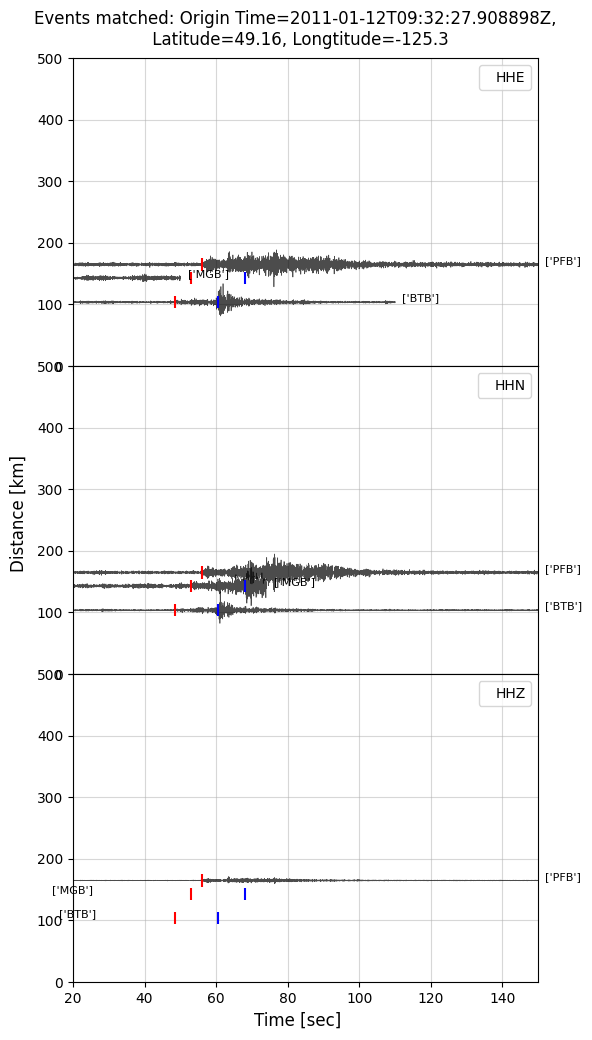

In [11]:
# parameters
idx=37
mycatalog= mycatalog
mycatalog_picks=mycatalog_picks
networks= all_picks_networks
channel= "HH?"
idx_sta= 50
title= "Events matched"
fig_title= "events_matched.png"
ylim= [0,500]
xlim= [20,150]

subplots_waveforms(idx,mycatalog,mycatalog_picks,networks,channel,idx_sta,title,fig_title,ylim,xlim)

### Plot the waveforms of the Unmatched events in Morton's catalog (no need to run the cells below)

In [ ]:
client = WaveformClient()
client2 = Client("IRIS")

In [ ]:
df = pd.read_csv('../data/all_picks_all_stations.csv')
df

In [ ]:
_df = df.drop_duplicates(subset='station_code')
_df

In [ ]:
networks_stas = np.array(_df[["station_network_code", "station_code" ]])
networks_stas

In [ ]:
new_events_lat_44_deg = unmatched_events_mycatalog2morton_and_anss.loc[(unmatched_events_mycatalog2morton_and_anss['latitude']>43.9)&(unmatched_events_mycatalog2morton_and_anss['latitude']<44.1)]
new_events_lat_44_deg

In [ ]:
unmatched_events_mycatalog2morton_and_anss

In [ ]:
# Plot the earthquake moveout for one of the unmatched events

idx = 0
event = unmatched_events_morton2mycatalog.iloc[idx]
otime = UTCDateTime(event['datetime'])
distances = []

# Assuming networks_stas is a list of tuples with network and station identifiers
for network, station in networks_stas:
    try:
        sta_inv = client2.get_stations(network=network, station=station, channel="?H?", 
                                       starttime=otime - 1e4, endtime=otime + 1e4)[0][0]
    except Exception as e:
        print(f"Failed to fetch for {network} {station} {otime}: {e}")
        continue

    slat = sta_inv.latitude
    slon = sta_inv.longitude
    olat = event['LAT']
    olon = event['LON']

    dis1 = locations2degrees(olat, olon, slat, slon)
    dist = degrees2kilometers(dis1)
    distances.append([network,station,dist])

# Sort distances
distances = sorted(distances, key=lambda item: item[-1])
# print(distances)
# print(otime)
plt.figure(figsize=(10,20), dpi=150)
for i, ii in enumerate(distances):
    st = client.get_waveforms(network=ii[0], station=ii[1], channel="?HZ", year=otime.year, month=otime.month, day=otime.day)
    st = obspy.Stream(filter(lambda st:st.stats.sampling_rate>10, st))
    st.filter(type='bandpass',freqmin=4,freqmax=15)

    trim_st = st.copy().trim(starttime = otime - 30, 
                endtime = otime + 120)
    if len(trim_st)>0:
        trim_st = trim_st.normalize()
        offsets1  = ii[2]
        offsets2 = 0
#         for ii in range(len(trim_st)):
        plt.plot(trim_st[0].times()-30,trim_st[0].data * 10+offsets1, 
                 color = 'gray', alpha=0.7, lw=0.5)    
#         time_pick = [[x['time_pick'], x['phase']] for _, x in mycatalog[mycatalog['idx'] == idx].iterrows() 
#                      if x['station'] == sta]
#         if len(time_pick) > 0:
#             for p in time_pick:
#                 if p[1] == 'P':
        plt.text(trim_st[0].times()[0] -47, trim_st[0].data[0] * 10 + offsets1-2, 
                     [ii[0],ii[1]], fontsize=8, verticalalignment='bottom')
    
        plt.vlines(ii[2]/5, offsets1-5, 
                         offsets1+5, color='r')
#                 else:
#                     plt.vlines(p[0], offsets1[ii]*0.5+offsets2[i]-1, 
#                                      offsets1[ii]*0.5+offsets2[i]+1, color='b')
    else:                 
        pass 
plt.title(f"Unmatched Earthquake between Our Catalog and Morton's Catalog: Origin Time={otime}")
plt.xlabel('Time [sec]')
plt.ylabel('Distance [km]')
plt.grid()


plt.show()

In [ ]:
# Plot the earthquake moveouts for the unmatched events for Morton's catalog
for idx in range(len(unmatched_events_morton2mycatalog)):
    event = unmatched_events_morton2mycatalog.iloc[idx]
    otime = UTCDateTime(event['datetime'])
    distances = []

    # Assuming networks_stas is a list of tuples with network and station identifiers
    for network, station in networks_stas:
        try:
            sta_inv = client2.get_stations(network=network, station=station, channel="?H?", 
                                           starttime=otime - 1e4, endtime=otime + 1e4)[0][0]
        except Exception as e:
            print(f"Failed to fetch for {network} {station} {otime}: {e}")
            continue

        slat = sta_inv.latitude
        slon = sta_inv.longitude
        olat = event['LAT']
        olon = event['LON']

        dis1 = locations2degrees(olat, olon, slat, slon)
        dist = degrees2kilometers(dis1)
        distances.append([network,station,dist])

    # Sort distances
    distances = sorted(distances, key=lambda item: item[-1])
    # print(distances)
    # print(otime)
    plt.figure(figsize=(10,20), dpi=150)
    for i, ii in enumerate(distances):
        st = client.get_waveforms(network=ii[0], station=ii[1], channel="?HZ", year=otime.year, month=otime.month, day=otime.day)
        st = obspy.Stream(filter(lambda st:st.stats.sampling_rate>10, st))
        st.filter(type='bandpass',freqmin=4,freqmax=15)

        trim_st = st.copy().trim(starttime = otime - 30, 
                    endtime = otime + 120)
        if len(trim_st)>0:
            trim_st = trim_st.normalize()
            offsets1  = ii[2]
            offsets2 = 0
    #         for ii in range(len(trim_st)):
            plt.plot(trim_st[0].times()-30,trim_st[0].data * 10+offsets1, 
                     color = 'gray', alpha=0.7, lw=0.5)    
    #         time_pick = [[x['time_pick'], x['phase']] for _, x in mycatalog[mycatalog['idx'] == idx].iterrows() 
    #                      if x['station'] == sta]
    #         if len(time_pick) > 0:
    #             for p in time_pick:
    #                 if p[1] == 'P':
            plt.text(trim_st[0].times()[0] -47, trim_st[0].data[0] * 10 + offsets1-2, 
                         [ii[0],ii[1]], fontsize=8, verticalalignment='bottom')

            plt.vlines(ii[2]/5, offsets1-5, 
                             offsets1+5, color='r')
    #                 else:
    #                     plt.vlines(p[0], offsets1[ii]*0.5+offsets2[i]-1, 
    #                                      offsets1[ii]*0.5+offsets2[i]+1, color='b')
        else:                 
            pass 
    plt.title(f"Unmatched Earthquake between Our Catalog and Morton's Catalog: Origin Time={otime}")
    plt.xlabel('Time [sec]')
    plt.ylabel('Distance [km]')
    plt.grid()


    plt.show()

### Plot the waveforms of the unmatched events in our catalog (newly found events at the Mendocino Junction)

In [ ]:
new_event_example_picks = mycatalog_picks.loc[mycatalog_picks['event_idx']==1037]
pick_sta = np.unique(new_event_example_picks['station'])
pick_sta

In [ ]:
# Plot the earthquake moveout for one of the unmatched events for all stations 
idx = 3
# event = new_events_deg.iloc[idx]
event=new_event_example_picks
# otime = UTCDateTime(event['datetime'])
otime =UTCDateTime(2012,10,31,23,36,25)
distances = []

# Assuming networks_stas is a list of tuples with network and station identifiers
for station in pick_sta:
    try:
        sta_inv = client2.get_stations(network="C8,7D,7A,CN,NV,UW,UO,NC,BK,TA,OO,PB,X6,Z5,X9",
                                       station=station, channel="?H?", 
                                       starttime=otime - 1e4, endtime=otime + 1e4)[0][0]
    except Exception as e:
        print(f"Failed to fetch for {network} {station} {otime}: {e}")
        continue

    slat = sta_inv.latitude
    slon = sta_inv.longitude
    olat = event['latitude']
    olon = event['longitude']

    dis1 = locations2degrees(olat, olon, slat, slon)
    dist = degrees2kilometers(dis1)
    distances.append([None,station,dist])

# Sort distances
distances = sorted(distances, key=lambda item: item[-1])
distances = distances[0:11]
# print(distances)
# print(otime)
plt.figure(dpi=150)
for i, ii in enumerate(distances):
    st = client.get_waveforms(network="*",
                              station=ii[1], channel="?HZ", starttime=otime-30, endtime=otime+120)
    st = obspy.Stream(filter(lambda st:st.stats.sampling_rate>10, st))
    st.filter(type='bandpass',freqmin=4,freqmax=15)
    
    trim_st = st.copy()
    if len(trim_st)>0:
        trim_st = trim_st.normalize()
        offsets1  = ii[2]
        offsets2 = 0
#         for ii in range(len(trim_st)):
        plt.plot(trim_st[0].times(),trim_st[0].data * 10+offsets1, 
                 color = 'black', alpha=0.7, lw=0.5)    
#         time_pick = [[x['time_pick'], x['phase']] for _, x in mycatalog[mycatalog['idx'] == idx].iterrows() 
#                      if x['station'] == sta]
#         if len(time_pick) > 0:
#             for p in time_pick:
#                 if p[1] == 'P':
        plt.text(trim_st[0].times()[0] -16, trim_st[0].data[0] * 10 + offsets1-2, 
                     [ii[1]], fontsize=8, verticalalignment='bottom')
    
#         plt.vlines(ii[2]/5, offsets1-5, 
#                          offsets1+5, color='r')
        sta_picks = new_event_example_picks.loc[new_event_example_picks['station']==ii[1]]
        
        p_picks = sta_picks.loc[sta_picks['phase']=='P']
        s_picks = sta_picks.loc[sta_picks['phase']=='S']

        
        if len(p_picks)>0:
            plt.vlines(UTCDateTime(p_picks.iloc[0]['time_pick'])-otime+30, offsets1-5, 
                         offsets1+5, color='r')
            
        if len(s_picks)>0:
            plt.vlines(UTCDateTime(s_picks.iloc[0]['time_pick'])-otime+30, offsets1-5, 
                         offsets1+5, color='b')

#                 else:
#                     plt.vlines(p[0], offsets1[ii]*0.5+offsets2[i]-1, 
#                                      offsets1[ii]*0.5+offsets2[i]+1, color='b')
    else:                 
        pass 
plt.title(f"New Event near the Mendocino Triple Junction: Origin Time={otime}, Latitude={event['latitude']}, Longtitude={event['longitude']}")
plt.xlabel('Time [sec]')
plt.ylabel('Distance [km]')
plt.ylim(20,120)
plt.xlim(5,100)

plt.grid(alpha=0.5)

plt.savefig("event_idx_1037.pdf", format="pdf", bbox_inches="tight")
plt.show()


In [ ]:
otime,trim_st[0].times()

In [ ]:
distances

### Plot the waveforms of the unmatched events in our catalog (newly found events offshore WA and OR)

In [ ]:
unmatched_events_mycatalog2morton_and_anss[(unmatched_events_mycatalog2morton_and_anss['picks']>0) & (unmatched_events_mycatalog2morton_and_anss['latitude']>45) & (unmatched_events_mycatalog2morton_and_anss['latitude']<48)&(unmatched_events_mycatalog2morton_and_anss['longitude']>-127) & (unmatched_events_mycatalog2morton_and_anss['longitude']<-124.5)]

In [ ]:
event_WA_OR = unmatched_events_mycatalog2morton_and_anss.loc[unmatched_events_mycatalog2morton_and_anss['idx']==49].iloc[0]
event_WA_OR

In [ ]:
new_event_example_picks_WA_OR = mycatalog_picks.loc[mycatalog_picks['idx']==event_WA_OR['idx']]
new_event_example_picks_WA_OR

In [ ]:
pick_sta_WA_OR=np.unique(new_event_example_picks_WA_OR['station'])
pick_sta_WA_OR

In [ ]:

# Plot the earthquake moveout for one of the unmatched events for all stations 
idx = 3
# event = new_events_deg.iloc[idx]
event=event_WA_OR
new_event_example_picks = new_event_example_picks_WA_OR
pick_sta = pick_sta_WA_OR

# otime = UTCDateTime(event['datetime'])
otime =UTCDateTime(event_WA_OR['datetime'])
distances = []

# Assuming networks_stas is a list of tuples with network and station identifiers
for station in pick_sta:
    try:
        sta_inv = client2.get_stations(network="C8,7D,7A,CN,NV,UW,UO,NC,BK,TA,OO,PB,X6,Z5,X9",
                                       station=station, channel="?H?", 
                                       starttime=otime - 1e4, endtime=otime + 1e4)[0][0]
    except Exception as e:
        print(f"Failed to fetch for {network} {station} {otime}: {e}")
        continue

    slat = sta_inv.latitude
    slon = sta_inv.longitude
    olat = event['latitude']
    olon = event['longitude']

    dis1 = locations2degrees(olat, olon, slat, slon)
    dist = degrees2kilometers(dis1)
    distances.append([None,station,dist])

# Sort distances
distances = sorted(distances, key=lambda item: item[-1])
distances = distances[0:11]
# print(distances)
# print(otime)
plt.figure(dpi=150)
for i, ii in enumerate(distances):
    st = client.get_waveforms(network="*",
                              station=ii[1], channel="?HZ", starttime=otime-30, endtime=otime+120)
    st = obspy.Stream(filter(lambda st:st.stats.sampling_rate>10, st))
    st.filter(type='bandpass',freqmin=4,freqmax=15)
    
    trim_st = st.copy()
    if len(trim_st)>0:
        trim_st = trim_st.normalize()
        offsets1  = ii[2]
        offsets2 = 0
#         for ii in range(len(trim_st)):
        plt.plot(trim_st[0].times(),trim_st[0].data * 10+offsets1, 
                 color = 'black', alpha=0.7, lw=0.5)    
#         time_pick = [[x['time_pick'], x['phase']] for _, x in mycatalog[mycatalog['idx'] == idx].iterrows() 
#                      if x['station'] == sta]
#         if len(time_pick) > 0:
#             for p in time_pick:
#                 if p[1] == 'P':
        plt.text(trim_st[0].times()[0]-5, trim_st[0].data[0] * 10 + offsets1-2, 
                     [ii[1]], fontsize=8, verticalalignment='bottom')
    
#         plt.vlines(ii[2]/5, offsets1-5, 
#                          offsets1+5, color='r')
        sta_picks = new_event_example_picks.loc[new_event_example_picks['station']==ii[1]]
        
        p_picks = sta_picks.loc[sta_picks['phase']=='P']
        s_picks = sta_picks.loc[sta_picks['phase']=='S']

        
        if len(p_picks)>0:
            plt.vlines(UTCDateTime(p_picks.iloc[0]['time_pick'])-otime+30, offsets1-5, 
                         offsets1+5, color='r')
            
        if len(s_picks)>0:
            plt.vlines(UTCDateTime(s_picks.iloc[0]['time_pick'])-otime+30, offsets1-5, 
                         offsets1+5, color='b')

#                 else:
#                     plt.vlines(p[0], offsets1[ii]*0.5+offsets2[i]-1, 
#                                      offsets1[ii]*0.5+offsets2[i]+1, color='b')
    else:                 
        pass 
plt.title(f"New Event Offshore WA and OR: Origin Time={otime}, Latitude={event['latitude']}, Longtitude={event['longitude']}")
plt.xlabel('Time [sec]')
plt.ylabel('Distance [km]')
# plt.ylim(20,120)
plt.xlim(20,140)

plt.grid(alpha=0.5)

plt.savefig("event_idx_49.pdf", format="pdf", bbox_inches="tight")
plt.show()


### Plot the waveforms of the unmatched events in our catalog (newly found events offshore WA and OR) #2

In [ ]:
event_WA_OR_idx_424 = unmatched_events_mycatalog2morton_and_anss.loc[unmatched_events_mycatalog2morton_and_anss['idx']==424].iloc[0]
event_WA_OR_idx_424

In [ ]:
new_event_example_picks_WA_OR_idx_424 = mycatalog_picks.loc[mycatalog_picks['event_idx']==event_WA_OR_idx_424['idx']]
new_event_example_picks_WA_OR_idx_424

In [ ]:
pick_sta_WA_OR_idx_424=np.unique(new_event_example_picks_WA_OR_idx_424['station'])
pick_sta_WA_OR_idx_424

In [ ]:
# Plot the earthquake moveout for one of the unmatched events for all stations 
idx = 3
# event = new_events_deg.iloc[idx]
event=event_WA_OR_idx_424
new_event_example_picks = new_event_example_picks_WA_OR_idx_424
pick_sta = pick_sta_WA_OR_idx_424

# otime = UTCDateTime(event['datetime'])
otime =UTCDateTime(event['datetime'])
distances = []

# Assuming networks_stas is a list of tuples with network and station identifiers
for station in pick_sta:
    try:
        sta_inv = client2.get_stations(network="C8,7D,7A,CN,NV,UW,UO,NC,BK,TA,OO,PB,X6,Z5,X9",
                                       station=station, channel="?H?", 
                                       starttime=otime - 1e4, endtime=otime + 1e4)[0][0]
    except Exception as e:
        print(f"Failed to fetch for {network} {station} {otime}: {e}")
        continue

    slat = sta_inv.latitude
    slon = sta_inv.longitude
    olat = event['latitude']
    olon = event['longitude']

    dis1 = locations2degrees(olat, olon, slat, slon)
    dist = degrees2kilometers(dis1)
    distances.append([None,station,dist])

# Sort distances
distances = sorted(distances, key=lambda item: item[-1])
distances = distances[0:11]
# print(distances)
# print(otime)
plt.figure(dpi=150)
for i, ii in enumerate(distances):
    st = client.get_waveforms(network="*",
                              station=ii[1], channel="?HZ", starttime=otime-30, endtime=otime+120)
    st = obspy.Stream(filter(lambda st:st.stats.sampling_rate>10, st))
    st.filter(type='bandpass',freqmin=4,freqmax=15)
    
    trim_st = st.copy()
    if len(trim_st)>0:
        trim_st = trim_st.normalize()
        offsets1  = ii[2]
        offsets2 = 0
#         for ii in range(len(trim_st)):
#         wave=trim_st[0].data
#         wave=wave/np.std(wave,axis=-1,keepdims=True)
        plt.plot(trim_st[0].times(),trim_st[0].data * 10+offsets1, 
                 color = 'black', alpha=0.7, lw=0.5)    
#         time_pick = [[x['time_pick'], x['phase']] for _, x in mycatalog[mycatalog['idx'] == idx].iterrows() 
#                      if x['station'] == sta]
#         if len(time_pick) > 0:
#             for p in time_pick:
#                 if p[1] == 'P':
        plt.text(trim_st[0].times()[0]-5, trim_st[0].data[0] * 10 + offsets1-2, 
                     [ii[1]], fontsize=8, verticalalignment='bottom')
    
#         plt.vlines(ii[2]/5, offsets1-5, 
#                          offsets1+5, color='r')
        sta_picks = new_event_example_picks.loc[new_event_example_picks['station']==ii[1]]
        
        p_picks = sta_picks.loc[sta_picks['phase']=='P']
        s_picks = sta_picks.loc[sta_picks['phase']=='S']

        
        if len(p_picks)>0:
            plt.vlines(UTCDateTime(p_picks.iloc[0]['time_pick'])-otime+30, offsets1-5, 
                         offsets1+5, color='r')
            
        if len(s_picks)>0:
            plt.vlines(UTCDateTime(s_picks.iloc[0]['time_pick'])-otime+30, offsets1-5, 
                         offsets1+5, color='b')

#                 else:
#                     plt.vlines(p[0], offsets1[ii]*0.5+offsets2[i]-1, 
#                                      offsets1[ii]*0.5+offsets2[i]+1, color='b')
    else:                 
        pass 
plt.title(f"Newly Found Events: Origin Time={otime}, Latitude={event['latitude']}, Longtitude={event['longitude']}")
plt.xlabel('Time [sec]')
plt.ylabel('Distance [km]')
# plt.ylim(20,120)
plt.xlim(20,140)

plt.grid(alpha=0.5)

plt.savefig("event_idx_424.pdf", format="pdf", bbox_inches="tight")
plt.show()


### Plot the waveforms of the unmatched events in our catalog (Near the seamount)

In [ ]:
unmatched_events_mycatalog2morton_and_anss

In [ ]:
abc=unmatched_events_mycatalog2morton_and_anss[(unmatched_events_mycatalog2morton_and_anss['longitude']<-126)]
abc.sort_values(by=['picks'])

In [ ]:
event_seamount = unmatched_events_mycatalog2morton_and_anss.loc[unmatched_events_mycatalog2morton_and_anss['idx']==274].iloc[0]
event_seamount

In [ ]:
new_event_example_picks_seamount_idx_926 = mycatalog_picks.loc[mycatalog_picks['event_idx']==event_seamount['idx']]
new_event_example_picks_seamount_idx_926

In [ ]:
pick_sta_seamount_idx_926=np.unique(new_event_example_picks_seamount_idx_926['station'])
pick_sta_seamount_idx_926

In [ ]:
# Plot the earthquake moveout for one of the unmatched events for all stations 
idx = 3
# event = new_events_deg.iloc[idx]
event=event_seamount
new_event_example_picks = new_event_example_picks_seamount_idx_926
pick_sta = pick_sta_seamount_idx_926

# otime = UTCDateTime(event['datetime'])
otime =UTCDateTime(event['datetime'])
distances = []

# Assuming networks_stas is a list of tuples with network and station identifiers
for station in pick_sta:
    try:
        sta_inv = client2.get_stations(network="C8,7D,7A,CN,NV,UW,UO,NC,BK,TA,OO,PB,X6,Z5,X9",
                                       station=station, channel="?H?", 
                                       starttime=otime - 1e4, endtime=otime + 1e4)[0][0]
    except Exception as e:
        print(f"Failed to fetch for {network} {station} {otime}: {e}")
        continue

    slat = sta_inv.latitude
    slon = sta_inv.longitude
    olat = event['latitude']
    olon = event['longitude']

    dis1 = locations2degrees(olat, olon, slat, slon)
    dist = degrees2kilometers(dis1)
    distances.append([None,station,dist])

# Sort distances
distances = sorted(distances, key=lambda item: item[-1])
distances = distances[0:11]
# print(distances)
# print(otime)
plt.figure(dpi=150)
for i, ii in enumerate(distances):
    st = client.get_waveforms(network="*",
                              station=ii[1], channel="?HZ", starttime=otime-30, endtime=otime+120)
    st = obspy.Stream(filter(lambda st:st.stats.sampling_rate>10, st))
    st.filter(type='bandpass',freqmin=4,freqmax=15)
    
    trim_st = st.copy()
    if len(trim_st)>0:
        trim_st = trim_st.normalize()
        offsets1  = ii[2]
        offsets2 = 0
#         for ii in range(len(trim_st)):
        wave=trim_st[0].data
        wave=wave/np.nanmax(wave,axis=-1,keepdims=True)
        plt.plot(trim_st[0].times(),wave *10+offsets1, 
                 color = 'black', alpha=0.7, lw=0.5)    
#         time_pick = [[x['time_pick'], x['phase']] for _, x in mycatalog[mycatalog['idx'] == idx].iterrows() 
#                      if x['station'] == sta]
#         if len(time_pick) > 0:
#             for p in time_pick:
#                 if p[1] == 'P':
        plt.text(trim_st[0].times()[0]-5, trim_st[0].data[0] * 10 + offsets1-2, 
                     [ii[1]], fontsize=8, verticalalignment='bottom')
    
#         plt.vlines(ii[2]/5, offsets1-5, 
#                          offsets1+5, color='r')
        sta_picks = new_event_example_picks.loc[new_event_example_picks['station']==ii[1]]
        
        p_picks = sta_picks.loc[sta_picks['phase']=='P']
        s_picks = sta_picks.loc[sta_picks['phase']=='S']

        
        if len(p_picks)>0:
            plt.vlines(UTCDateTime(p_picks.iloc[0]['time_pick'])-otime+30, offsets1-5, 
                         offsets1+5, color='r')
            
        if len(s_picks)>0:
            plt.vlines(UTCDateTime(s_picks.iloc[0]['time_pick'])-otime+30, offsets1-5, 
                         offsets1+5, color='b')

#                 else:
#                     plt.vlines(p[0], offsets1[ii]*0.5+offsets2[i]-1, 
#                                      offsets1[ii]*0.5+offsets2[i]+1, color='b')
    else:                 
        pass 
plt.title(f"Newly Found Events: Origin Time={otime}, Latitude={event['latitude']}, Longtitude={event['longitude']}")
plt.xlabel('Time [sec]')
plt.ylabel('Distance [km]')
plt.ylim(0,200)
plt.xlim(20,100)

plt.grid(alpha=0.5)

plt.savefig("event_idx_274.pdf", format="pdf", bbox_inches="tight")
plt.show()

## Plot the earthquake moveout for one of the unmatched events for all stations 


In [ ]:
# Plot the earthquake moveout for one of the unmatched events for all stations 
idx = 0
event = unmatched_events_mycatalog2morton_and_anss.iloc[idx]
otime = UTCDateTime(event['datetime'])
distances = []

# Assuming networks_stas is a list of tuples with network and station identifiers
for network, station in networks_stas:
    try:
        sta_inv = client2.get_stations(network=network, station=station, channel="?H?", 
                                       starttime=otime - 1e4, endtime=otime + 1e4)[0][0]
    except Exception as e:
        print(f"Failed to fetch for {network} {station} {otime}: {e}")
        continue

    slat = sta_inv.latitude
    slon = sta_inv.longitude
    olat = event['latitude']
    olon = event['longitude']

    dis1 = locations2degrees(olat, olon, slat, slon)
    dist = degrees2kilometers(dis1)
    distances.append([network,station,dist])

# Sort distances
distances = sorted(distances, key=lambda item: item[-1])
# distances = distances[0:4]
# print(distances)
# print(otime)
plt.figure(figsize=(10,20), dpi=150)
for i, ii in enumerate(distances):
    st = client.get_waveforms(network=ii[0], station=ii[1], channel="?HZ", year=otime.year, month=otime.month, day=otime.day)
    st = obspy.Stream(filter(lambda st:st.stats.sampling_rate>10, st))
    st.filter(type='bandpass',freqmin=4,freqmax=15)

    trim_st = st.copy().trim(starttime = otime - 30, 
                endtime = otime + 120)
    if len(trim_st)>0:
        trim_st = trim_st.normalize()
        offsets1  = ii[2]
        offsets2 = 0
#         for ii in range(len(trim_st)):
        plt.plot(trim_st[0].times()-30,trim_st[0].data * 10+offsets1, 
                 color = 'gray', alpha=0.7, lw=0.5)    
#         time_pick = [[x['time_pick'], x['phase']] for _, x in mycatalog[mycatalog['idx'] == idx].iterrows() 
#                      if x['station'] == sta]
#         if len(time_pick) > 0:
#             for p in time_pick:
#                 if p[1] == 'P':
        plt.text(trim_st[0].times()[0] -47, trim_st[0].data[0] * 10 + offsets1-2, 
                     [ii[0],ii[1]], fontsize=8, verticalalignment='bottom')
    
        plt.vlines(ii[2]/5, offsets1-5, 
                         offsets1+5, color='r')
#                 else:
#                     plt.vlines(p[0], offsets1[ii]*0.5+offsets2[i]-1, 
#                                      offsets1[ii]*0.5+offsets2[i]+1, color='b')
    else:                 
        pass 
plt.title(f"Unmatched Earthquake between Our Catalog and Morton's Catalog in Our Catalog (Newly Found Events): Origin Time={otime}")
plt.xlabel('Time [sec]')
plt.ylabel('Distance [km]')
# plt.ylim(80,120)
plt.grid()


plt.show()

In [ ]:
# Plot the earthquake moveout for one of the unmatched events for all stations 
idx = 3
event = unmatched_events_mycatalog2morton_and_anss.iloc[idx]
otime = UTCDateTime(event['datetime'])
distances = []

# Assuming networks_stas is a list of tuples with network and station identifiers
for network, station in networks_stas:
    try:
        sta_inv = client2.get_stations(network=network, station=station, channel="?H?", 
                                       starttime=otime - 1e4, endtime=otime + 1e4)[0][0]
    except Exception as e:
        print(f"Failed to fetch for {network} {station} {otime}: {e}")
        continue

    slat = sta_inv.latitude
    slon = sta_inv.longitude
    olat = event['latitude']
    olon = event['longitude']

    dis1 = locations2degrees(olat, olon, slat, slon)
    dist = degrees2kilometers(dis1)
    distances.append([network,station,dist])

# Sort distances
distances = sorted(distances, key=lambda item: item[-1])
distances = distances[0:8]
# print(distances)
# print(otime)
plt.figure()
for i, ii in enumerate(distances):
    st = client.get_waveforms(network=ii[0], station=ii[1], channel="?HZ", year=otime.year, month=otime.month, day=otime.day)
    st = obspy.Stream(filter(lambda st:st.stats.sampling_rate>10, st))
    st.filter(type='bandpass',freqmin=4,freqmax=15)

    trim_st = st.copy().trim(starttime = otime - 30, 
                endtime = otime + 120)
    if len(trim_st)>0:
        trim_st = trim_st.normalize()
        offsets1  = ii[2]
        offsets2 = 0
#         for ii in range(len(trim_st)):
        plt.plot(trim_st[0].times()-30,trim_st[0].data * 5+offsets1, 
                 color = 'gray', alpha=0.7, lw=0.5)    
#         time_pick = [[x['time_pick'], x['phase']] for _, x in mycatalog[mycatalog['idx'] == idx].iterrows() 
#                      if x['station'] == sta]
#         if len(time_pick) > 0:
#             for p in time_pick:
#                 if p[1] == 'P':
        plt.text(trim_st[0].times()[0] -47, trim_st[0].data[0] * 10 + offsets1-2, 
                     [ii[0],ii[1]], fontsize=8, verticalalignment='bottom')
    
        plt.vlines(ii[2]/5, offsets1-5, 
                         offsets1+5, color='r')
#                 else:
#                     plt.vlines(p[0], offsets1[ii]*0.5+offsets2[i]-1, 
#                                      offsets1[ii]*0.5+offsets2[i]+1, color='b')
    else:                 
        pass 
plt.title(f"Unmatched Earthquake between Our Catalog and Morton's Catalog in Our Catalog (Newly Found Events): Origin Time={otime}")
plt.xlabel('Time [sec]')
plt.ylabel('Distance [km]')
# plt.ylim(80,120)
plt.grid()


plt.show()

## Plot the earthquake moveout for one of the unmatched events for some stations 


In [ ]:
# Plot the earthquake moveout for one of the unmatched events
idx = 0
event = unmatched_events_mycatalog2morton_and_anss.iloc[idx]
otime = UTCDateTime(event['datetime'])
distances = []

# Assuming networks_stas is a list of tuples with network and station identifiers
for network, station in networks_stas:
    try:
        sta_inv = client2.get_stations(network=network, station=station, channel="?H?", 
                                       starttime=otime - 1e4, endtime=otime + 1e4)[0][0]
    except Exception as e:
        print(f"Failed to fetch for {network} {station} {otime}: {e}")
        continue

    slat = sta_inv.latitude
    slon = sta_inv.longitude
    olat = event['latitude']
    olon = event['longitude']

    dis1 = locations2degrees(olat, olon, slat, slon)
    dist = degrees2kilometers(dis1)
    distances.append([network,station,dist])

# Sort distances
distances = sorted(distances, key=lambda item: item[-1])
# print(distances)
# print(otime)
plt.figure(figsize=(10,20), dpi=150)
for i, ii in enumerate(distances):
    st = client.get_waveforms(network=ii[0], station=ii[1], channel="?HZ", year=otime.year, month=otime.month, day=otime.day)
    st = obspy.Stream(filter(lambda st:st.stats.sampling_rate>10, st))
    st.filter(type='bandpass',freqmin=4,freqmax=15)

    trim_st = st.copy().trim(starttime = otime - 30, 
                endtime = otime + 120)
    if len(trim_st)>0:
        trim_st = trim_st.normalize()
        offsets1  = ii[2]
        offsets2 = 0
#         for ii in range(len(trim_st)):
        plt.plot(trim_st[0].times()-30,trim_st[0].data * 10+offsets1, 
                 color = 'gray', alpha=0.7, lw=0.5)    
#         time_pick = [[x['time_pick'], x['phase']] for _, x in mycatalog[mycatalog['idx'] == idx].iterrows() 
#                      if x['station'] == sta]
#         if len(time_pick) > 0:
#             for p in time_pick:
#                 if p[1] == 'P':
        plt.text(trim_st[0].times()[0] -47, trim_st[0].data[0] * 10 + offsets1-2, 
                     [ii[0],ii[1]], fontsize=8, verticalalignment='bottom')
    
        plt.vlines(ii[2]/5, offsets1-5, 
                         offsets1+5, color='r')
#                 else:
#                     plt.vlines(p[0], offsets1[ii]*0.5+offsets2[i]-1, 
#                                      offsets1[ii]*0.5+offsets2[i]+1, color='b')
    else:                 
        pass 
plt.title(f"Unmatched Earthquake between Our Catalog and Morton's Catalog in Our Catalog (Newly Found Events): Origin Time={otime}")
plt.xlabel('Time [sec]')
plt.ylabel('Distance [km]')
plt.grid()


plt.show()

In [ ]:
# Plot the earthquake moveouts for the unmatched events for our catalog

ls_idx = np.arange(0,30) # Choose the indices of the events to plot
for idx in ls_idx:
    # Plot the earthquake moveout for one of the unmatched events

    event = unmatched_events_mycatalog2morton_and_anss.iloc[idx]
    otime = UTCDateTime(event['datetime'])
    distances = []

    # Assuming networks_stas is a list of tuples with network and station identifiers
    for network, station in networks_stas:
        try:
            sta_inv = client2.get_stations(network=network, station=station, channel="?H?", 
                                           starttime=otime - 1e4, endtime=otime + 1e4)[0][0]
        except Exception as e:
            print(f"Failed to fetch for {network} {station} {otime}: {e}")
            continue

        slat = sta_inv.latitude
        slon = sta_inv.longitude
        olat = event['latitude']
        olon = event['longitude']

        dis1 = locations2degrees(olat, olon, slat, slon)
        dist = degrees2kilometers(dis1)
        distances.append([network,station,dist])

    # Sort distances
    distances = sorted(distances, key=lambda item: item[-1])
    # print(distances)
    # print(otime)
    plt.figure(figsize=(10,20), dpi=150)
    for i, ii in enumerate(distances):
        st = client.get_waveforms(network=ii[0], station=ii[1], channel="?HZ", year=otime.year, month=otime.month, day=otime.day)
        st = obspy.Stream(filter(lambda st:st.stats.sampling_rate>10, st))
        st.filter(type='bandpass',freqmin=4,freqmax=15)

        trim_st = st.copy().trim(starttime = otime - 30, 
                    endtime = otime + 120)
        if len(trim_st)>0:
            trim_st = trim_st.normalize()
            offsets1  = ii[2]
            offsets2 = 0
    #         for ii in range(len(trim_st)):
            plt.plot(trim_st[0].times()-30,trim_st[0].data * 10+offsets1, 
                     color = 'gray', alpha=0.7, lw=0.5)    
    #         time_pick = [[x['time_pick'], x['phase']] for _, x in mycatalog[mycatalog['idx'] == idx].iterrows() 
    #                      if x['station'] == sta]
    #         if len(time_pick) > 0:
    #             for p in time_pick:
    #                 if p[1] == 'P':
            plt.text(trim_st[0].times()[0] -47, trim_st[0].data[0] * 10 + offsets1-2, 
                         [ii[0],ii[1]], fontsize=8, verticalalignment='bottom')

            plt.vlines(ii[2]/5, offsets1-5, 
                             offsets1+5, color='r')
    #                 else:
    #                     plt.vlines(p[0], offsets1[ii]*0.5+offsets2[i]-1, 
    #                                      offsets1[ii]*0.5+offsets2[i]+1, color='b')
        else:                 
            pass 
    plt.title(f"Unmatched Earthquake between Our Catalog and Morton's Catalog in Our Catalog (Newly Found Events): Origin Time={otime}")
    plt.xlabel('Time [sec]')
    plt.ylabel('Distance [km]')
    plt.grid()


    plt.show()

## Plot the earthquake moveout for one of the matched events for all stations 


In [ ]:
# Plot the earthquake moveout for one of the unmatched events
idx = 0
event = matched_events_mycatalog2morton.iloc[idx]
otime = UTCDateTime(event['datetime'])
distances = []

# Assuming networks_stas is a list of tuples with network and station identifiers
for network, station in networks_stas:
    try:
        sta_inv = client2.get_stations(network=network, station=station, channel="?H?", 
                                       starttime=otime - 1e4, endtime=otime + 1e4)[0][0]
    except Exception as e:
        print(f"Failed to fetch for {network} {station} {otime}: {e}")
        continue

    slat = sta_inv.latitude
    slon = sta_inv.longitude
    olat = event['latitude']
    olon = event['longitude']

    dis1 = locations2degrees(olat, olon, slat, slon)
    dist = degrees2kilometers(dis1)
    distances.append([network,station,dist])

# Sort distances
distances = sorted(distances, key=lambda item: item[-1])
# print(distances)
# print(otime)
plt.figure(figsize=(10,20), dpi=150)
for i, ii in enumerate(distances):
    st = client.get_waveforms(network=ii[0], station=ii[1], channel="?HZ", year=otime.year, month=otime.month, day=otime.day)
    st = obspy.Stream(filter(lambda st:st.stats.sampling_rate>10, st))
    st.filter(type='bandpass',freqmin=4,freqmax=15)

    trim_st = st.copy().trim(starttime = otime - 30, 
                endtime = otime + 120)
    if len(trim_st)>0:
        trim_st = trim_st.normalize()
        offsets1  = ii[2]
        offsets2 = 0
#         for ii in range(len(trim_st)):
        plt.plot(trim_st[0].times()-30,trim_st[0].data * 10+offsets1, 
                 color = 'gray', alpha=0.7, lw=0.5)    
#         time_pick = [[x['time_pick'], x['phase']] for _, x in mycatalog[mycatalog['idx'] == idx].iterrows() 
#                      if x['station'] == sta]
#         if len(time_pick) > 0:
#             for p in time_pick:
#                 if p[1] == 'P':
        plt.text(trim_st[0].times()[0] -47, trim_st[0].data[0] * 10 + offsets1-2, 
                     [ii[0],ii[1]], fontsize=8, verticalalignment='bottom')
    
        plt.vlines(ii[2]/5, offsets1-5, 
                         offsets1+5, color='r')
#                 else:
#                     plt.vlines(p[0], offsets1[ii]*0.5+offsets2[i]-1, 
#                                      offsets1[ii]*0.5+offsets2[i]+1, color='b')
    else:                 
        pass 
plt.title(f"Unmatched Earthquake between Our Catalog and Morton's Catalog in Our Catalog (Newly Found Events): Origin Time={otime}")
plt.xlabel('Time [sec]')
plt.ylabel('Distance [km]')
plt.grid()


plt.show()